### Notebook to genereate cross sections from TC output binned according to a 3D variable

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
4/23/22

In [11]:
# NOTE: Using copied tracking from CTL for NCRF tests

from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
import subprocess
import sys
# from thermo_functions import theta_virtual, relh, theta_equiv, density_moist
# from mask_tc_track import mask_tc_track

#### Main settings

In [12]:
storm = 'haiyan'
# storm = 'maria'

main_tag = 'vmf'#'isent'#'vmf'#
# isent: isentropic mass flux: *summed* vmf as a function of theta-e
# vmf: theta-e *averaged* as a function of vmf

# IVAR: Index variable (independent var)
# AVGVAR: Variable to bin (dependent var)
#   i.e., AVGVAR will be averaged as a function of IVAR
if main_tag == 'isent':
    ivar_select = 'th_e' # options: th_e, vmf
    avgvar_select = 'vmf' # options: vmf, th_e
    do_prm_xy = 0 # Calculate anomaly as deviation from xy-mean
elif main_tag == 'vmf':
    ivar_select = 'vmf' # options: th_e, vmf
    avgvar_select = 'th_e' # options: vmf, th_e
    do_prm_xy = 1 # Calculate anomaly as deviation from xy-mean

# Contour variable (3D; dependent var)
contvar_select = 'w'

ntall=[1,2,3,6]
ntall=[3]
nntall=np.shape(ntall)[0]

#### Additional settings and directories

In [13]:
# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'

# Tests to read and compare
# tests = ['crfon','ncrf']
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']

# Shift starting-read time step for CRFON comparison
t0_test=0
if tests[0] == 'crfon':
    t0_test=24
    memb0=5 # for CRFFON test

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
# nmem = 4
enstag = str(nmem)
# Starting member to read
memb0=1

nums=np.arange(memb0,nmem+memb0,1); nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

# TC tracking
ptrack='600' # tracking pressure level
var_track = 'rvor' # variable
rmax = 8 # radius (deg) limit for masking around TC center

In [14]:
datdir2 = 'post/d02/'

##### Get dimensions

datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
datdir3d = datdir #+'v2/'
varfil_main = Dataset(datdir3d+'T.nc')
nz = varfil_main.dimensions['level'].size
# lat = varfil_main.variables['XLAT'][:][0] # deg
# lon = varfil_main.variables['XLONG'][:][0] # deg
nx1 = varfil_main.dimensions['lat'].size
nx2 = varfil_main.dimensions['lon'].size
pres = varfil_main.variables['pres'][:] # hPa
dp = (pres[1]-pres[0])*1e2 # Pa
varfil_main.close()

process = subprocess.Popen(['ls '+main+storm+'/'+memb_all[0]+'/'+tests[0]+'/wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
varfil_main.close()

#### NetCDF variable read functions

In [15]:
# Strat/Conv index subset
def get_strattag(istrat):
    if istrat == -1:
        strattag='All'
    elif istrat == 0:
        strattag='Nonrain'
    elif istrat == 1:
        strattag='Conv'
    elif istrat == 2:
        strattag='Strat'
    elif istrat == 3:
        strattag='StratConv'
    return strattag

def var_read_3d(datdir,varname,t0,t1):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,:,:,:]
    varfil_main.close()
    return var
def var_read_2d(datdir,varname,t0,t1):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,:,:,:]
    varfil_main.close()
    return var

#### Index aka Bin variable

In [16]:
# Variable settings

# Theta-e
if ivar_select == 'th_e':
    fmin=315; fmax=365 # K
    step=1
    bins=np.arange(fmin,fmax+step,step)
    xlabel=r'$\theta_e$ [K]'
    log_x='linear'
    ivmean_label='th_e'
elif ivar_select == 'vmf':
    bins=np.logspace(-3,1.1,num=20)
    bins=np.concatenate((-1.*np.flip(bins),bins))
    xlabel='kg m$^{-2}$ s$^{-1}$'
    log_x='symlog'
    ivmean_label='vmf'

nbins = np.size(bins)

# Create axis of bin center-points for plotting
bin_axis = (bins[np.arange(nbins-1)]+bins[np.arange(nbins-1)+1])/2

# Vertical mass flux
if avgvar_select == 'vmf':
    v_label=avgvar_select
    v_units='kg / m2 / s'

    # Figure settings
    title = 'VMF'
    figtag = avgvar_select
    scale=1e-2
    units_var1 = '10$^2$ kg/s/K'
    xrange=[320,360]
    cmap='RdBu_r'
    cmax=20; cmin=-1*cmax
    cmax_diff=0.5; cmin_diff=-1*cmax_diff

# Theta-e (equivalent potential temperature)
elif avgvar_select == 'th_e':
    v_label=avgvar_select
    v_units='K'

    # Figure settings
    title = r"$\theta_e'$ [K]"
    figtag = avgvar_select
    scale=1 #e-2
    units_var1 = 'K'
    xrange=[-5,5]
    cmap='RdBu_r'
    cmax=20; cmin=-1*cmax
    cmax_diff=0.5; cmin_diff=-1*cmax_diff

#### Main loops and compositing

In [17]:
# Read in binned data

# Settings based on how data was written out:
# Number of sample time steps
nt=12
# nt=6
hr_tag = str(np.char.zfill(str(nt), 2))

# Arrays to save variables
nstrat=5 # -1-all, 0-non-raining, 1-conv, 2-strat, 3-conv+strat
ntest=2
var_binned=np.zeros((nstrat,ntest,nmem,nt,nz,nbins-1))
ivar_mean=np.zeros((nstrat,ntest,nmem,nt,nz))

for istrat in range(nstrat):
# for istrat in range(3,4):

    # Strat/Conv index subset
    strattag = get_strattag(istrat-1)

    for ktest in range(ntest):

        test_str=tests[ktest]

        # This has been tested for corresponding time steps:
        #   t0=37,1 are the first divergent time steps in CTL,NCRF
        #   t0=25,1 are the first divergent time steps in NCRF,CRFON
        if test_str == 'ctl':
            if tests[1] == 'ncrf36h':
                t0=36
            elif tests[1] == 'ncrf48h':
                t0=48
        elif test_str == 'ncrf36h':
            t0=t0_test
        elif test_str == 'ncrf48h':
            t0=t0_test
        elif test_str == 'crfon':
            t0=0

        t0+=1 # add one time step since NCRF(t=0) = CTL
        t1 = t0+nt

        print('Running test: ',test_str)

        # Loop over ensemble members

        for imemb in range(nmem):
        
            # print('Running imemb: ',memb_all[imemb])
        
            datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
            datdir3d = datdir #+'v2/'

            # Read data
            ex_tag='t0'+str(t0)

            avgvar_tag = avgvar_select
            if (do_prm_xy == 1): avgvar_tag+='_xyp'
            file_in = datdir+'binned_'+main_tag+'_'+avgvar_tag+'_'+strattag.lower()+'_'+hr_tag+'hr_'+ex_tag+'.nc'

            # print(file_out)
            ncfile = Dataset(file_in,mode='r')
            # print(ncfile.variables)
            bin_axis = ncfile.variables['bins'][:]

            var_binned[istrat,ktest,imemb,:,:,:] = ncfile.variables[v_label][:,:,:]
            ivar_mean[istrat,ktest,imemb,:,:] = ncfile.variables[ivmean_label][:,:]

            ncfile.close()

# #### Average variables across time and ens member
var_binned = np.mean(var_binned, axis=2)
ivar_mean = np.mean(ivar_mean, axis=2)

Running test:  ctl
Running test:  ncrf36h
Running test:  ctl
Running test:  ncrf36h
Running test:  ctl
Running test:  ncrf36h
Running test:  ctl
Running test:  ncrf36h
Running test:  ctl
Running test:  ncrf36h


---
### Plotting routines

In [18]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

### Figure settings

In [19]:
# Three-dimensional dependent variables ("var")

# Vertical mass flux
if avgvar_select == 'vmf':
    title = 'VMF'
    figtag = avgvar_select
    scale=1 #e-2
    units_var1 = 'kg/s/K'
    xrange=[320,360]
    cmap='RdBu_r'
    cmax=20; cmin=-1*cmax
    cmax_diff=0.5; cmin_diff=-1*cmax_diff
# Equiv pot temp
elif avgvar_select == 'th_e':
    title = r"$\theta_e$"
    figtag = avgvar_select
    scale=1 #e-2
    units_var1 = 'K'
    xrange=[np.min(bin_axis), np.max(bin_axis)]
    cmap='RdBu_r'
    cmax=20; cmin=-1*cmax
    cmax_diff=0.5; cmin_diff=-1*cmax_diff

### Main Cross Section

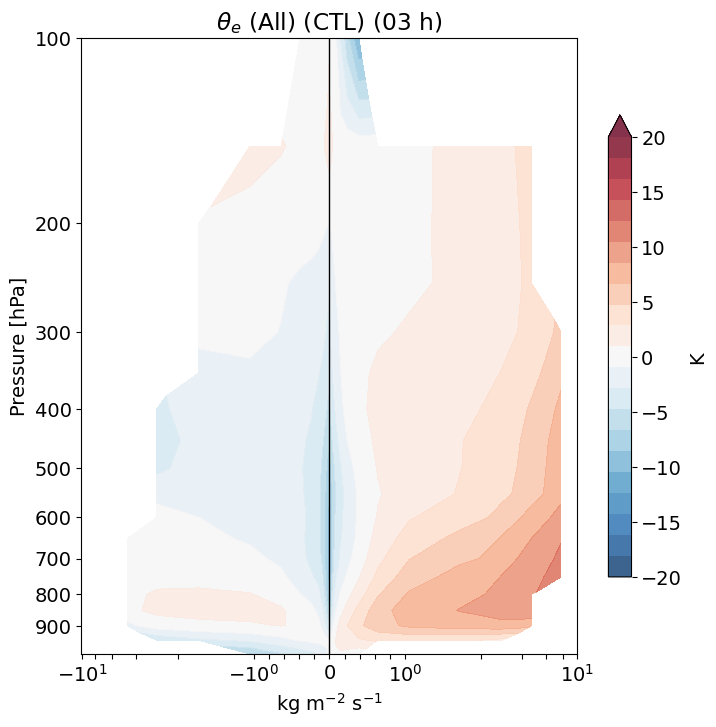

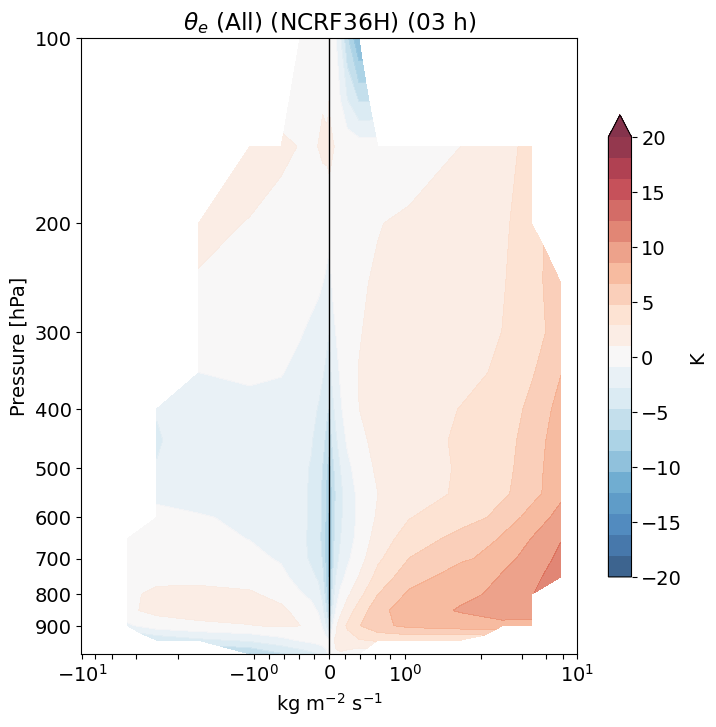

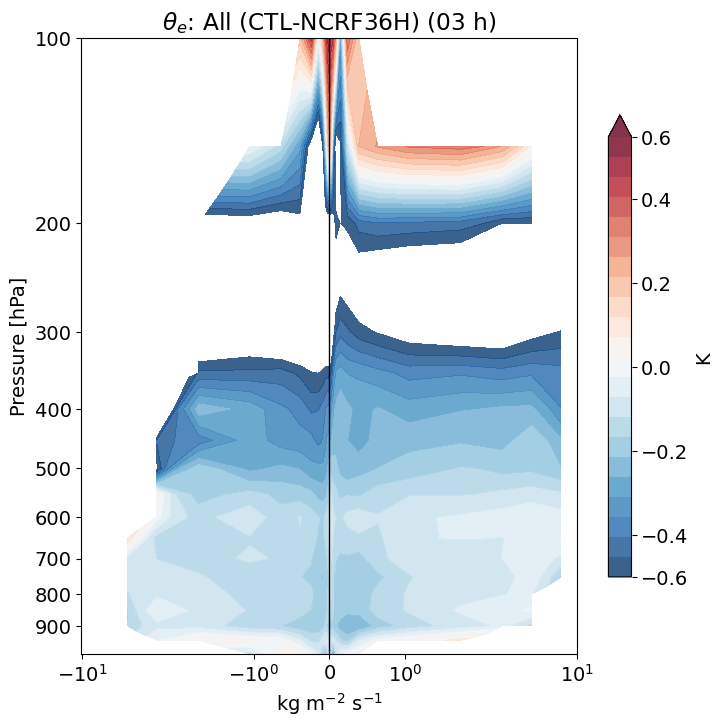

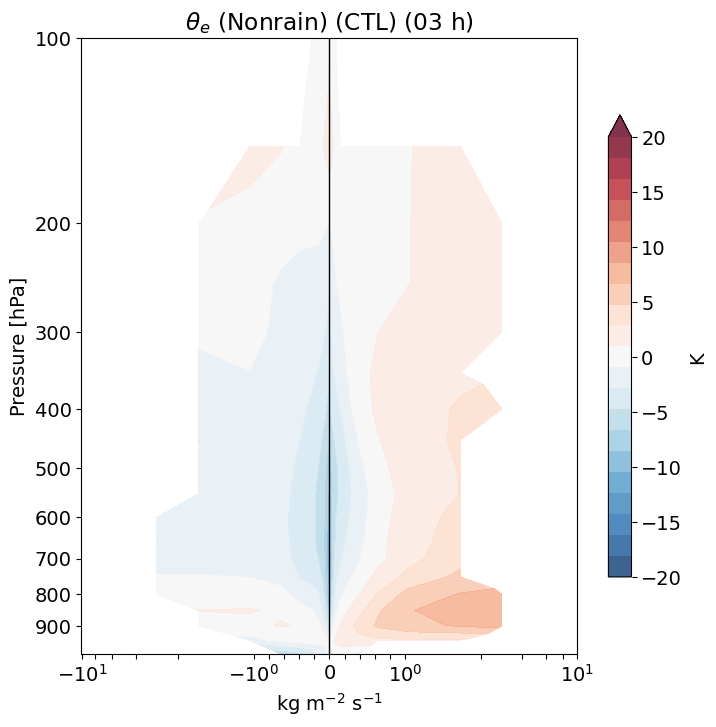

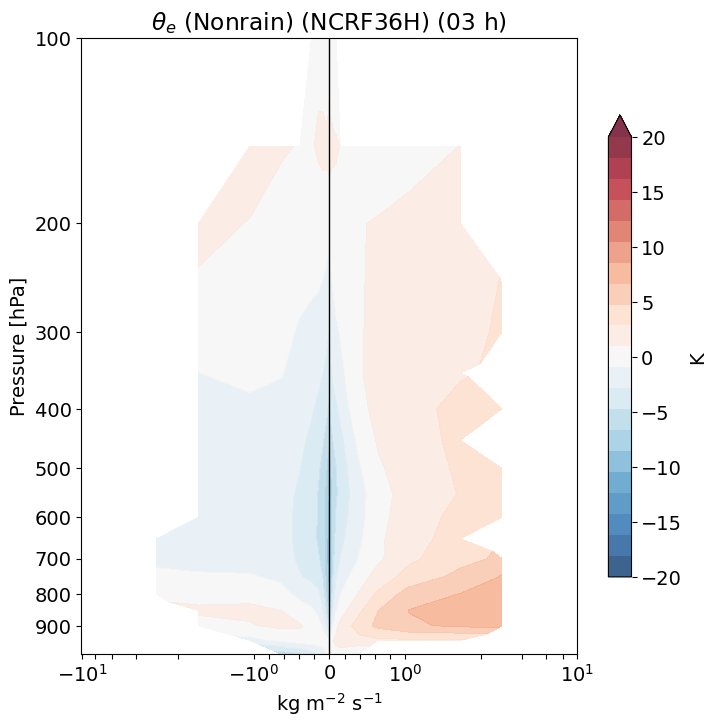

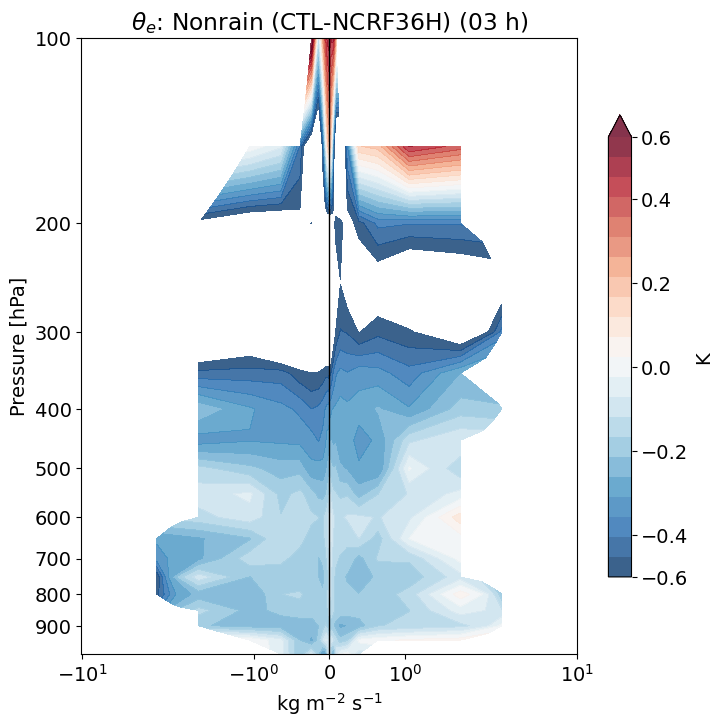

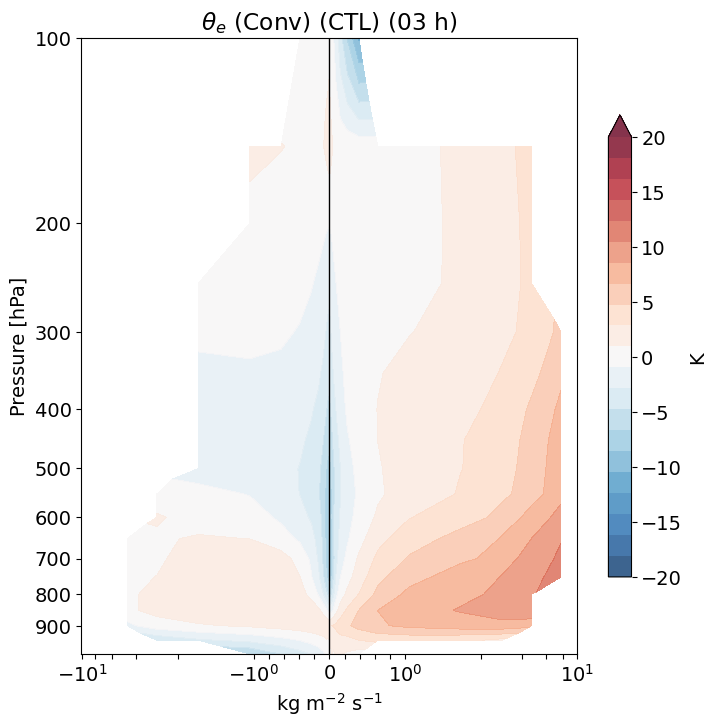

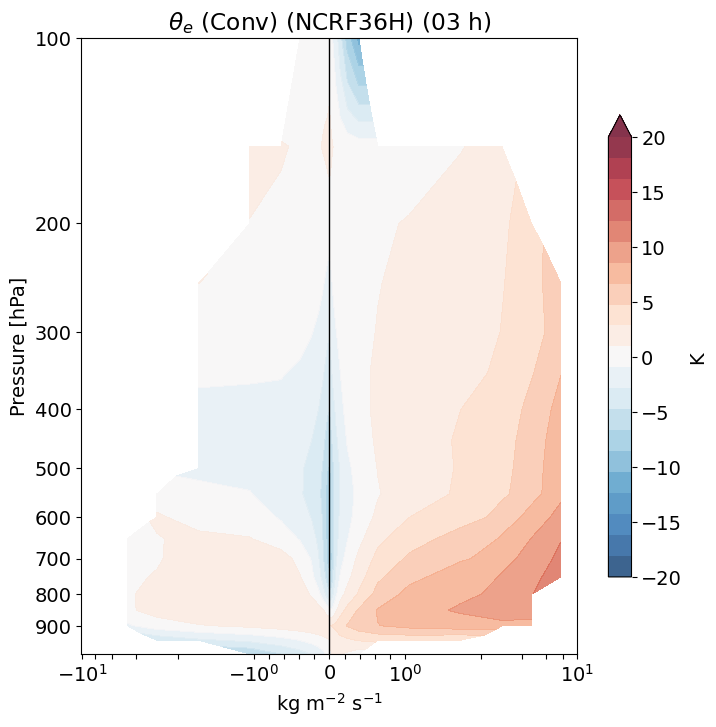

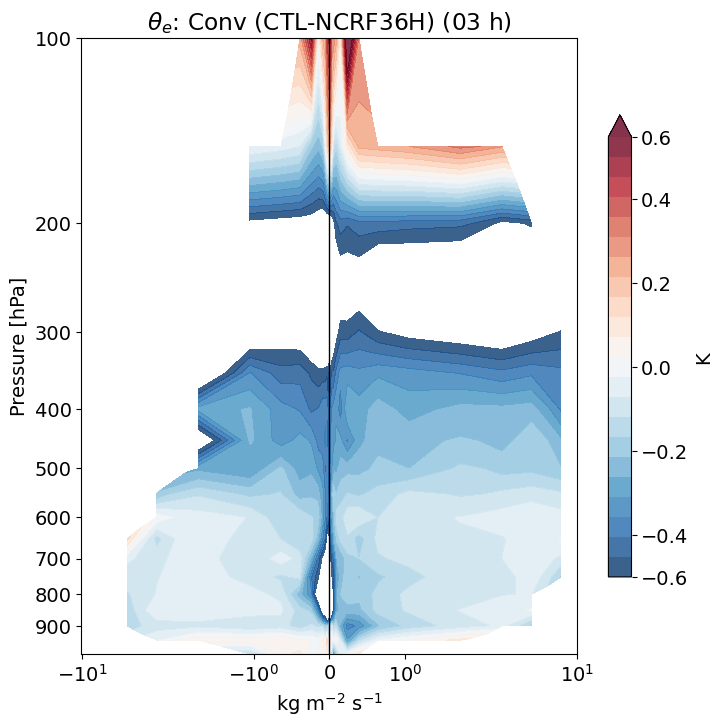

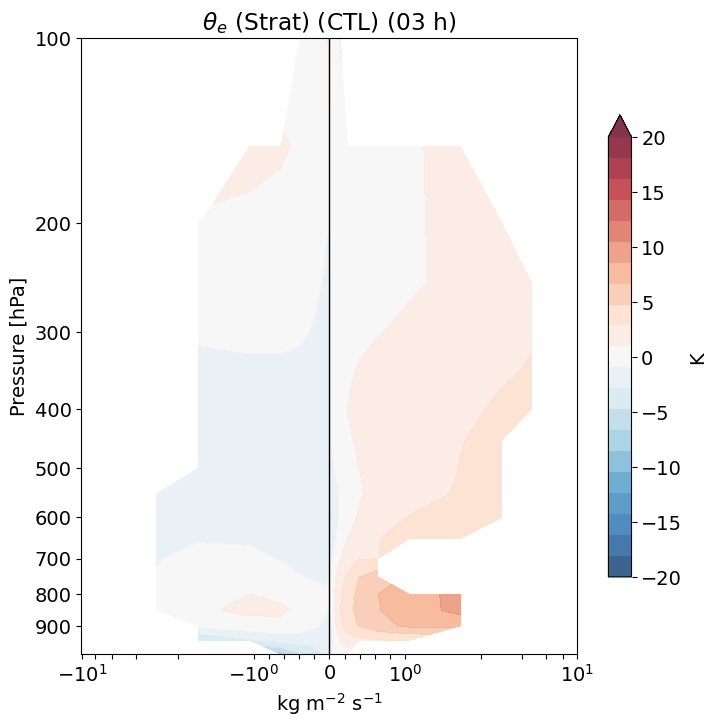

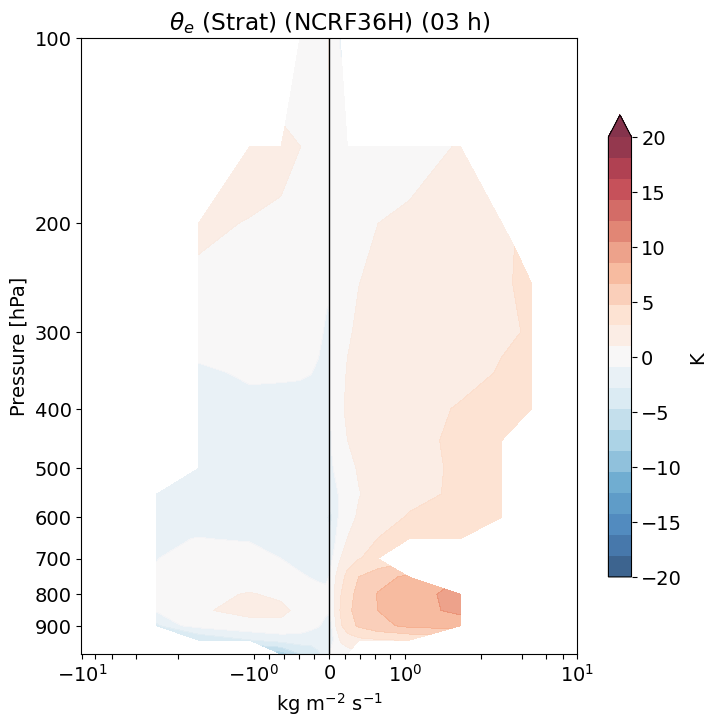

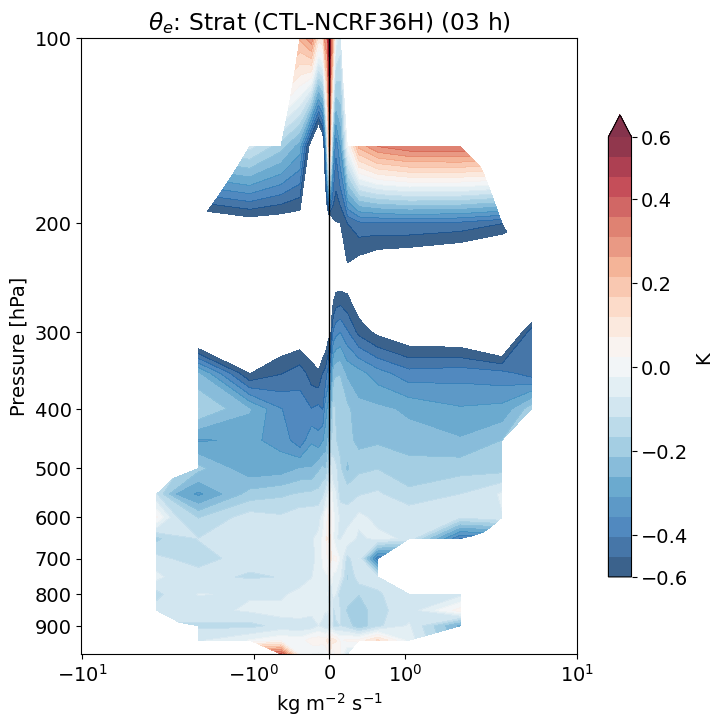

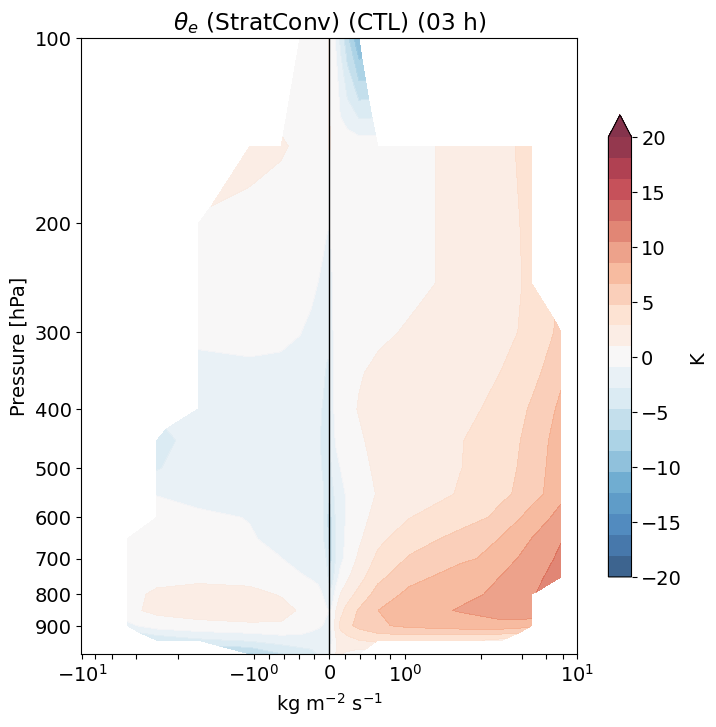

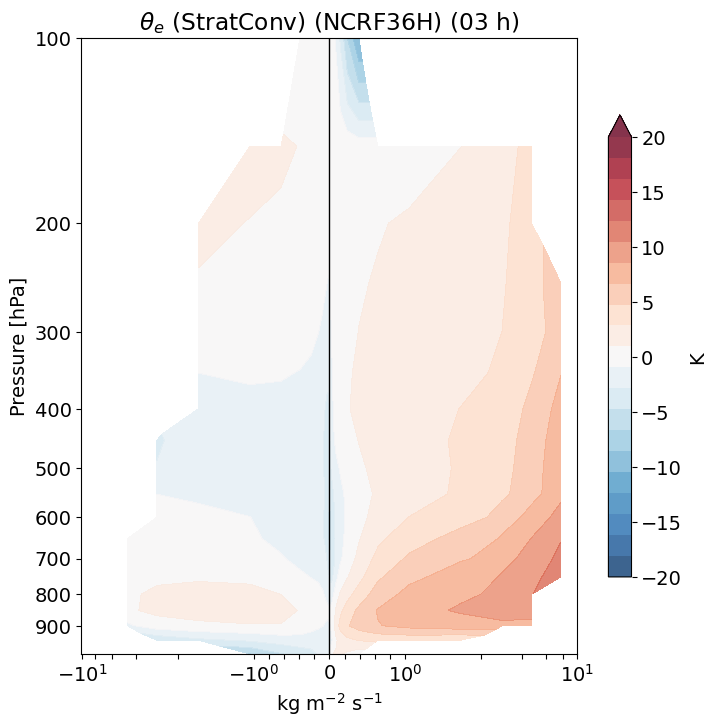

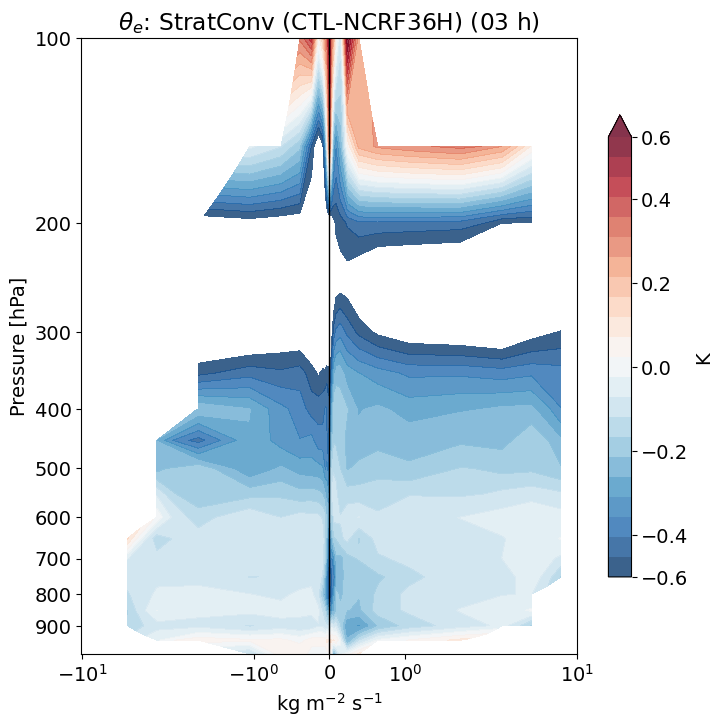

In [20]:
# Mask out all points except [stratiform/nonrain/etc], or switch off

# 0-non-raining, 1-conv, 2-strat, 3-other/anvil, (-1 for off)

for istrat in range(nstrat):
# for istrat in range(0,1):

    # Strat/Conv index subset
    strattag = get_strattag(istrat-1)

    for knt in range(nntall):

        i_nt=ntall[knt]
        hr_tag = str(np.char.zfill(str(i_nt), 2))

        # #### Average across time and ens member
        ivar_mn = np.mean(ivar_mean[istrat,:,0:i_nt,:], axis=1)
        ivar_binned = np.mean(var_binned[istrat,:,0:i_nt,:,:], axis=1)

        # Loop over sensitivity tests
        for ktest in range(ntest):
        # for ktest in range(0,1):

            test_str=tests[ktest].upper()
            fig_title = title+' ('+strattag+') ('+test_str.upper()+') ('+hr_tag+' h)'
            
            # create figure
            # fig = plt.figure(figsize=(14,8))
            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111)

            ax.set_title(fig_title)
            ax.set_ylabel('Pressure [hPa]')

            pltvar=ivar_binned[ktest,:,:]*scale

            ax.set_xscale(log_x)

            if ivar_select == 'vmf':
                ax.set_xscale('symlog')
                # clevsi=np.concatenate(([1e-2],np.arange(2,11,2)*1e-2,np.arange(2,11,2)*1e-1,np.arange(2,11,2)*1e-0))
                locmin = ticker.SymmetricalLogLocator(base=10.0,linthresh=2,subs=np.arange(2,11,2)*0.1)
                ax.xaxis.set_major_locator(locmin)
                # else: #if iplot == 'thv' or iplot == 'the':
                    # if iplot == 'qrad':
                    #   clevsi=np.concatenate(([1e-2],np.arange(2,11,2)*1e-2,np.arange(2,11,2)*1e-1,np.arange(2,11,2)*1e0,np.arange(2,11,2)*1e1))
                    # else:
                    #   clevsi=np.concatenate(([1e-2],np.arange(2,11,2)*1e-2,np.arange(2,11,2)*1e-1,np.arange(2,11,2)*1e0))

            # fill contour
            nlevs=21
            inc=(cmax-cmin)/nlevs
            clevs = np.arange(cmin, cmax+inc, inc)
            im = ax.contourf(bins[0:nbins-1], pres, pltvar, clevs, cmap=cmap, alpha=0.8, \
                            extend='max', zorder=2)

            cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
            cbar.ax.set_ylabel(units_var1)

            plt.ylim(100,np.max(pres))
            ax.invert_yaxis()
            ax.set_yscale('log')
            ytick_loc=np.arange(900,0,-100)
            plt.yticks(ticks=ytick_loc)
            ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

            ax.set_xlabel(xlabel)
            plt.xlim(xrange)
            # plt.grid(True, which="both", ls="-")

            if ivar_select == 'vmf':
                plt.axvline(x=0,color='k',linewidth=1.)

            # Plot mean theta-e profile
            if ivar_select != 'vmf':
                plt.plot(ivar_mn[ktest,:], pres, "-k")

            # ax2=ax.twinx()
            # im = ax.plot(bins[0:nbins-1], binvar_s_mn)

            # # line contour
            # strmfn = np.zeros((nz,nbins))
            # for ik in range(nz):
            #     for ibin in range(1,nbins-1):
            #         if np.isnan(var_binned[ktest,ik,ibin]):
            #             continue
            #         strmfn[ik,ibin] = strmfn[ik,ibin-1] + var_binned[ktest,ik,ibin]
            # stm_inc=3
            # clevs = np.arange(stm_inc, 20*stm_inc, stm_inc)
            # clevs = np.concatenate((-1*np.flip(clevs),clevs))
            # cvar = strmfn*1e-2
            # im = ax.contour(bins, pres, cvar, clevs, colors='black', zorder=2)
            # ax.clabel(im, im.levels, inline=True, fontsize=13)

            fig_extra='_'+strattag.lower()
            figtag2 = figtag+'_'+ivar_select+fig_extra
            plt.savefig(figdir+'binnedcross_'+figtag2+'_'+tests[ktest].lower()+'_ens'+enstag+'m_'+hr_tag+'.png',dpi=200, facecolor='white', \
                        bbox_inches='tight', pad_inches=0.2)
            plt.show()
            plt.close()


        # DIFFERENCE PLOT between sensitivity tests

        fig_title = title+': '+strattag+' ('+tests[0].upper()+'-'+tests[1].upper()+') ('+hr_tag+' h)'

        # create figure
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)

        ax.set_title(fig_title)
        ax.set_ylabel('Pressure [hPa]')

        pltvar =  ivar_binned[0,:,:] - ivar_binned[1,:,:]
        pltvar*=scale

        # fill contour
        nlevs=21
        inc=(cmax_diff-cmin_diff)/nlevs
        clevs = np.arange(cmin_diff, cmax_diff+inc, inc)
        im = ax.contourf(bins[0:nbins-1], pres, pltvar, clevs, cmap='RdBu_r', alpha=0.8, \
                        extend='max', zorder=2)

        cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
        cbar.ax.set_ylabel(units_var1)

        plt.ylim(100,np.max(pres))
        ax.invert_yaxis()
        ax.set_yscale('log')
        ytick_loc=np.arange(900,0,-100)
        plt.yticks(ticks=ytick_loc)
        ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

        ax.set_xscale(log_x)
        ax.set_xlabel(xlabel)
        plt.xlim(xrange)
        # plt.grid(True, which="both", ls="-")

        if ivar_select == 'vmf':
            plt.axvline(x=0,color='k',linewidth=1.)

        # Plot mean theta-e profile
        if ivar_select != 'vmf':
            plt.plot(np.mean(ivar_mn,axis=0), pres, "-k")

        figtag2 = figtag+'_'+ivar_select+fig_extra
        plt.savefig(figdir+'binnedcross_'+figtag2+'_diff_ens'+enstag+'m_'+hr_tag+'.png',dpi=200, facecolor='white', \
                    bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()